# Creating Training loop for descriptor "O_Front"

In [1]:
import sys

sys.path.append('..')
sys.path

import tensorflow as tf

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from skimage.transform import resize
import math
import pandas as pd
from ie590_project_nonGIT.model.input_fn import input_fn_features
from ie590_project_nonGIT.utils.utils import Params, build_train_validate

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

print('Using device: ', device)


Num GPUs Available:  1
Using device:  /device:GPU:0


In [3]:
#Building Train and Validation Sets. Default ratio is 80%train, 20%test
#build_train_validate('data_descriptors_mode.csv')

In [7]:
params = Params('params.json')
is_training = True
params.dict

{'update': 'params.json',
 'learning_rate': 1e-05,
 'batch_size': 200,
 'num_epochs': 10,
 'reg_scale': 0.0001,
 'num_ch': 6,
 'image_height': 240,
 'image_width': 320,
 'max_frames': 25,
 'image_resize': 240,
 'num_parallel_calls': 4,
 'save_summary_steps': 1,
 'train_path': 'train.csv',
 'validation_path': 'validation.csv',
 'prediction_path': 'unseen_predictions.csv',
 'dataset_path': '/home/jupyter/CV_Project/ie590_project/data/IsoGD_phase_1/',
 'descriptors': 'O_Front',
 'descriptor_type': 'mode'}

## Checking Label Distribution

1    0.504997
0    0.495003
Name: O_Front, dtype: float64


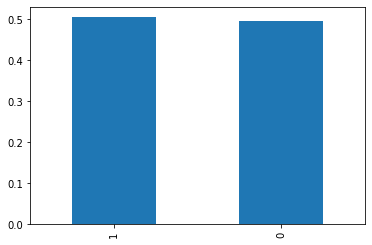

In [5]:
descriptor = params.descriptors
df = pd.read_csv(params.train_path,usecols=[descriptor])
dist = df[descriptor].value_counts(normalize=True)
print(dist)
dist.plot(kind='bar')


Slight imbalance in the distribution. Must Evaluate by AUC

In [4]:
#Pick between channel='rgb'/'d'/'both'
class VGG16_FC(tf.keras.Model):
    def __init__(self, hidden_size_1, hidden_size_2, num_classes=2, channels='both'):
        super(VGG16_FC, self).__init__()        
        #self.input_layer = tf.keras.layers.InputLayer(input_shape=num_features*25),
        self.channels = channels
        self.fc1 = tf.keras.layers.Dense(hidden_size_1
                                         , activation=tf.nn.leaky_relu)
        self.fc2 = tf.keras.layers.Dense(hidden_size_2
                                         , activation=tf.nn.leaky_relu)
        self.fc3 = tf.keras.layers.Dense(num_classes
                                         , activation='softmax')
        if self.channels == 'rgb':
            self.ix = 0
        else:
            self.ix = 1
    

    def call(self, x, training=False):
        if self.channels == 'both':
            x = np.concatenate([x[:,0,:,:],x[:,1,:,:]],axis=2)
        else:
            x = x[:,self.ix,:,:]
        frame_features = []
        for i in range(x.shape[1]):
            frame_features.append(x[:,i,:])
        x = np.concatenate(frame_features,axis=1)
        #x = self.input_layer(x)
        x = self.fc1(x)      
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

class VGG16_LSTM(tf.keras.Model):
    def __init__(self, num_features=512, hidden_size_1=128, num_classes=2, channels='both', dropout=0.2):
        super(VGG16_LSTM, self).__init__()        
        #self.input_layer = tf.keras.layers.InputLayer(input_shape=num_features*25),
        self.channels = channels
        if self.channels == 'both':
            num_features *= 2
            hidden_size_1 *= 2
        self.lstm = tf.keras.layers.LSTM(num_features, return_sequences=False,
                                               input_shape=(25,),
                                               dropout=dropout)
        self.fc1 = tf.keras.layers.Dense(hidden_size_1,activation=tf.nn.leaky_relu)
        self.dropout = tf.keras.layers.Dropout(dropout)
        self.fc2 = tf.keras.layers.Dense(num_classes,activation='softmax')
        if channels == 'rgb':
            self.ix = 0
        else:
            self.ix = 1
    

    def call(self, x, training=False):
        if self.channels == 'both':
            x = np.concatenate([x[:,0,:,:],x[:,1,:,:]],axis=2)
        else:
            x = x[:,self.ix,:,:]
        #x = self.input_layer(x)
        x = self.lstm(x)      
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#layers = [tf.compat.v2.keras.layers.InputLayer(12800),
          #tf.compat.v2.keras.layers.Dense(2000, activation='relu'),
          #tf.compat.v2.keras.layers.Dense(200, activation='relu'),
          #tf.compat.v2.keras.layers.Dense(2, activation='softmax')
         #]
#model = tf.keras.Sequential(layers)

def model_init_fn():
    model = VGG16_FC(hidden_size_1=2000, hidden_size_2=200, 
                     num_classes=2, channels='both')
    return model

def model_init_fn_lstm():
    model = VGG16_LSTM(channels='both')
    return model

In [7]:
train = input_fn_features(is_training=True,params=params)
val = input_fn_features(is_training=False,params=params)
#{images, targets, iterator.}

Loading Training Data from: train.csv
Loading Validation Data from: validation.csv


# Training Loop

In [9]:
def train_part34(model_init_fn,is_training,compile_params):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Model, History (Loss, AUC, Recall, Accuracy)
    """    
    with tf.device(compile_params['device']):

        # Compute the loss like we did in Part II
        loss_fn = tf.keras.losses.BinaryCrossentropy()
        
        model = model_init_fn()
        optimizer = tf.keras.optimizers.Adam(learning_rate=compile_params["learning_rate"])
        #Calculate Loss
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        val_loss = tf.keras.metrics.Mean(name='val_loss')
        #Area Under Curve 
        train_auc = tf.keras.metrics.AUC(name='train_auc')
        val_auc = tf.keras.metrics.AUC(name='val_auc')
        #Recall
        train_recall = tf.keras.metrics.Recall(name='train_recall')
        val_recall = tf.keras.metrics.Recall(name='val_recall')
        #Accuracy
        train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
        val_accuracy = tf.keras.metrics.BinaryAccuracy(name='val_accuracy')
        
        #Logging all the above for plots later on
        train_loss_log = []
        val_loss_log = []
        train_auc_log = []
        val_auc_log = []
        train_recall_log = []
        val_recall_log = []
        train_accuracy_log = []
        val_accuracy_log = []
        
        t = 0
        for epoch in range(compile_params["num_epochs"]):
            train_dset = iter(compile_params['train_data'])
            
            # Reset the metrics - https://www.tensorflow.org/alpha/guide/migration_guide#new-style_metrics
            train_loss.reset_states()
            train_accuracy.reset_states()
            train_recall.reset_states()
            train_auc.reset_states()
    
            
            for x_np, y_np in train_dset:
                y_np = tf.keras.utils.to_categorical(y_np, num_classes = 2, dtype = 'int32')
                with tf.GradientTape() as tape:
                    
                    # Use the model function to build the forward pass.
                    scores = model(x_np, training=True)
                    loss = loss_fn(y_np, scores)
      
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    
                    # Update the metrics
                    train_loss.update_state(loss)
                    train_auc.update_state(y_np, scores)
                    train_recall.update_state(y_np, scores)
                    train_accuracy.update_state(y_np, scores)
                    
                    if t % compile_params["print_every"] == 0:
                        val_loss.reset_states()
                        val_accuracy.reset_states()
                        val_recall.reset_states()
                        val_auc.reset_states()
                        
                        val_dset = iter(compile_params['val_data'])
                        
                        for test_x, test_y in val_dset:
                            # During validation at end of epoch, training set to False
                            test_y = tf.keras.utils.to_categorical(test_y, num_classes = 2)
                            prediction = model(test_x, training=False)
                            t_loss = loss_fn(test_y, prediction)
                            
                            val_loss.update_state(t_loss)
                            sparse_prediction = tf.keras.utils.to_categorical(np.argmax(prediction,axis=1), num_classes = 2)
                            val_auc.update_state(test_y, prediction)
                            val_recall.update_state(test_y, sparse_prediction)
                            val_accuracy.update_state(test_y, prediction)
                            #print("Debug:",val_accuracy.result())

                        
                        template = 'Iteration {}, Epoch {}, Train Loss: {}, Train {}: {}, Val Loss: {}, Val {}: {}'
                        print (template.format(t, epoch+1, 
                                             train_loss.result(),
                                            compile_params['metric'],
                                             train_accuracy.result(),
                                             val_loss.result(),
                                            compile_params['metric'],
                                             val_accuracy.result()))
                    t += 1
            train_loss_log.append(train_loss.result())
            val_loss_log.append(val_loss.result())
            train_auc_log.append(train_auc.result())
            val_auc_log.append(val_auc.result())
            train_recall_log.append(train_recall.result())
            val_recall_log.append(val_recall.result())
            train_accuracy_log.append(train_accuracy.result())
            val_accuracy_log.append(val_accuracy.result())   
            history = {"loss":{"train":train_loss_log,"validation":val_loss_log},
                      "auc":{"train":train_auc_log,"validation":val_auc_log},
                      "recall":{"train":train_recall_log,"validation":val_recall_log},
                      "accuracy":{"train":train_accuracy_log,"validation":val_accuracy_log}}
        return(model,history)

# Run Training Loop

In [10]:
compile_params = {
    "device": device,
    "train_data": train,
    "val_data": val,
    "learning_rate": 0.00001,
    "num_epochs": 30,
    "metric": "Accuracy",
    "descriptor_type": "mode",
    "print_every": 40,
}
o_front_model_fc, o_front_history_fc = train_part34(model_init_fn,is_training,compile_params)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iteration 0, Epoch 1, Train Loss: 0.7378841638565063, Train Accuracy: 0.4449999928474426, Val Loss: 0.8038291335105896, Val Accuracy: 0.49000465869903564
Iteration 40, Epoch 1, Train Loss: 0.646966278553009, Train Accuracy: 0.6368292570114136, Val Loss: 0.5892171263694763, Val Accuracy: 0.7131567001342773
Iteration 80, Epoch 2, Train Loss: 0.5821599364280701, Train Accuracy: 0.7032432556152344, Val Loss: 0.5207

In [ ]:
compile_params = {
    "device": device,
    "train_data": train,
    "val_data": val,
    "learning_rate": 0.0001,
    "num_epochs": 20,
    "metric": "Accuracy",
    "descriptor_type": "mode",
    "print_every": 40,
}
o_front_model_lstm, o_front_history_lstm = train_part34(model_init_fn_lstm,is_training,compile_params)

In [12]:
def plot_stuff(model_plt, title):
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(15, 10)
    axs[0, 0].plot(model_plt['loss']['train'])
    axs[0, 0].plot(model_plt['loss']['validation'])
    axs[0, 0].set_title('Loss')
    axs[0, 0].set(ylabel='Loss')
    axs[0, 1].plot(model_plt['accuracy']['train'])
    axs[0, 1].plot(model_plt['accuracy']['validation'])
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set(ylabel='Accuracy')
    axs[1, 0].plot(model_plt['auc']['train'])
    axs[1, 0].plot(model_plt['auc']['validation'])
    axs[1, 0].set_title('AUC')
    axs[1, 0].set(ylabel='AUC')
    axs[1, 1].plot(model_plt['recall']['train'])
    axs[1, 1].plot(model_plt['recall']['validation'])
    axs[1, 1].set_title('Recall')
    axs[1, 1].set(ylabel='Recall')

    for ax in axs.flat:
        ax.set(xlabel='Epochs')

    fig.suptitle(title)
    fig.legend(['train', 'test'], loc='upper left')
    fig.show()


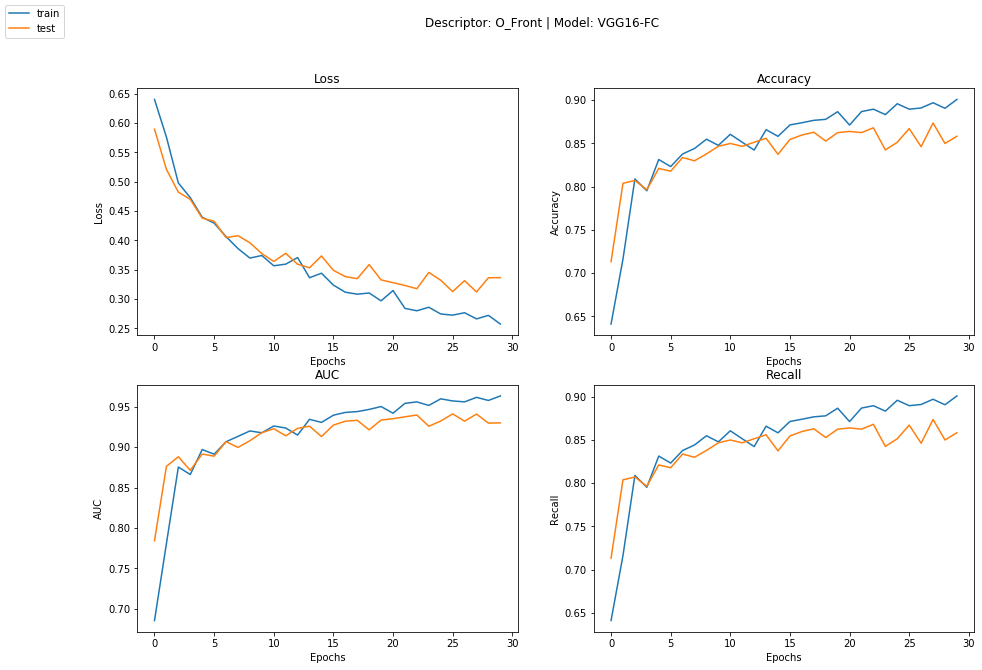

In [13]:
# summarize history for loss
model_plt = o_front_history_fc
plot_stuff(model_plt, title = 'Descriptor: O_Front | Model: VGG16-FC')

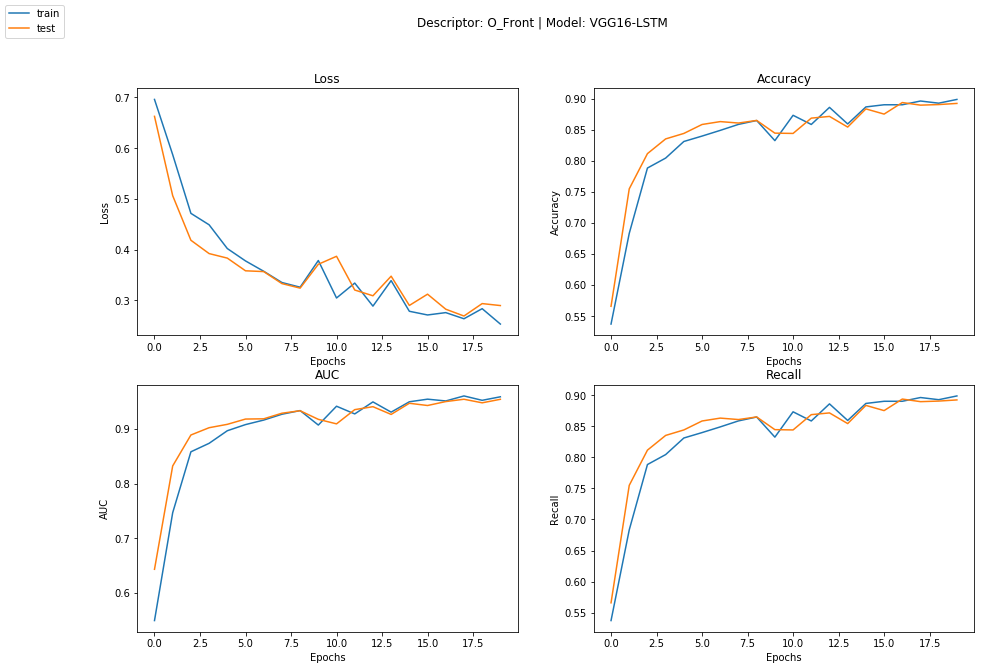

In [18]:
# summarize history for loss
model_plt = o_front_history_lstm
plot_stuff(model_plt, title = 'Descriptor: O_Front | Model: VGG16-LSTM')

In [ ]:
#Plot ROC Curves
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [14]:
#Save Models
o_front_model_fc.save_weights('/home/jupyter/CV_Project/ie590_project/ie590_project_nonGIT/model/o_front_model_fc')
o_front_model_lstm.save_weights('/home/jupyter/CV_Project/ie590_project/ie590_project_nonGIT/model/o_front_model_lstm')

## Make Predictions 

In [5]:
#Load Models
fc_model_loaded = VGG16_FC(2000,200)
fc_filepath = '/home/jupyter/CV_Project/ie590_project/ie590_project_nonGIT/model/o_front_model_fc'
fc_model_loaded.load_weights(fc_filepath)

lstm_model_loaded = VGG16_LSTM()
lstm_filepath = '/home/jupyter/CV_Project/ie590_project/ie590_project_nonGIT/model/o_front_model_lstm'
lstm_model_loaded.load_weights(lstm_filepath)

In [11]:
params.descriptor_type = 'mean'
def predict_descriptor(model_weights, descriptor, csv_file = 'unseen_predictions.csv'):
    input_pred = input_fn_features(is_training=False,params=params,prediction_mode=True)
    pred_data = iter(input_pred)
    predictions = []
    for x_pred, __ in pred_data:
        preds = model_weights(x_pred, training=False)
        preds = np.argmax(preds.numpy(),axis=1)
        for i in preds:
            predictions.append(i)
    df = pd.read_csv(csv_file)
    df[descriptor] = predictions 
    df.to_csv(csv_file, index=False)
    print("Updated predictions on %s"%csv_file)

In [12]:
predict_descriptor(lstm_model_loaded,'O_Front')

Loading Test Data from: unseen_predictions.csv

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Updated predictions on unseen_predictions.csv
